# DATA SCIENTIST COURSE (PROJECT 3)

### DATA EXPLORATION

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("reviews.csv")

X = df.drop("Recommended IND", axis=1)
y = df["Recommended IND"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [2]:
df.head()

,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,1


In [3]:
df.shape

(18442, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB


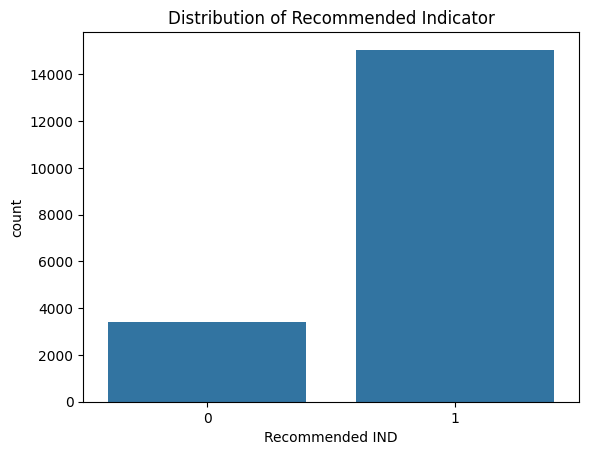

In [5]:
df["Recommended IND"].value_counts()
sns.countplot(data=df, x="Recommended IND")
plt.title("Distribution of Recommended Indicator")
plt.show()


This data set is imbalanced, F1 score will be the most accurate metric to evaluate this models.

In [6]:
df.isnull().sum().sort_values(ascending=False)

Clothing ID                0
Age                        0
Title                      0
Review Text                0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
Recommended IND            0
dtype: int64

There are no missing values in this dataset

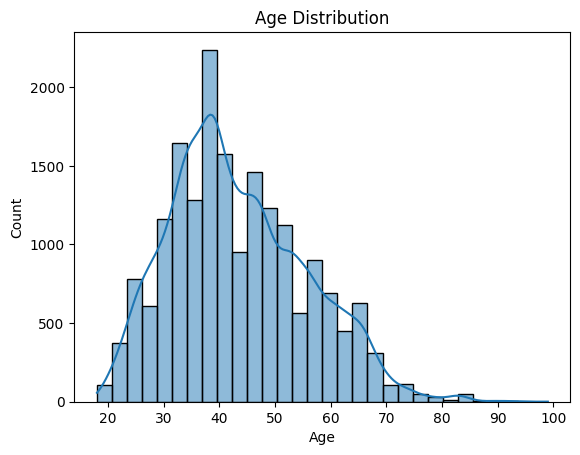

In [7]:
sns.histplot(df["Age"].dropna(), bins=30, kde=True)
plt.title("Age Distribution")
plt.show()


The age distribution is approximately bell-shaped, with most customers concentrated between 30 and 50 years old. Very young and very old customers are less frequent, indicating that the dataset mainly represents a middle-aged customer base.

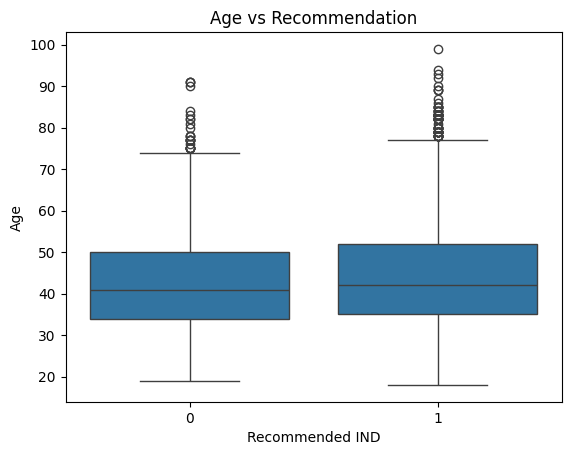

In [8]:
sns.boxplot(x="Recommended IND", y="Age", data=df)
plt.title("Age vs Recommendation")
plt.show()


The age distributions for recommended and non-recommended products are very similar. This suggests that age alone is not a strong predictor of whether a customer recommends a product, although it may still provide useful complementary information.

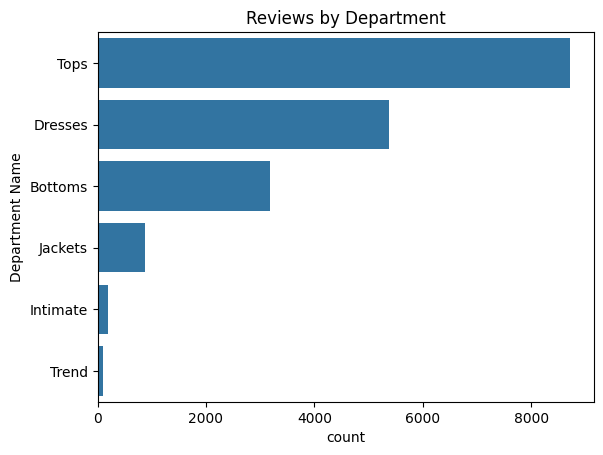

In [9]:
df["Division Name"].value_counts()
df["Department Name"].value_counts().head(10)
sns.countplot(
    data=df,
    y="Department Name",
    order=df["Department Name"].value_counts().index
)
plt.title("Reviews by Department")
plt.show()


The number of reviews varies significantly across departments, with Tops and Dresses generating the highest volume of reviews. This imbalance indicates that product category is an important feature and should be properly encoded to avoid bias toward dominant departments.

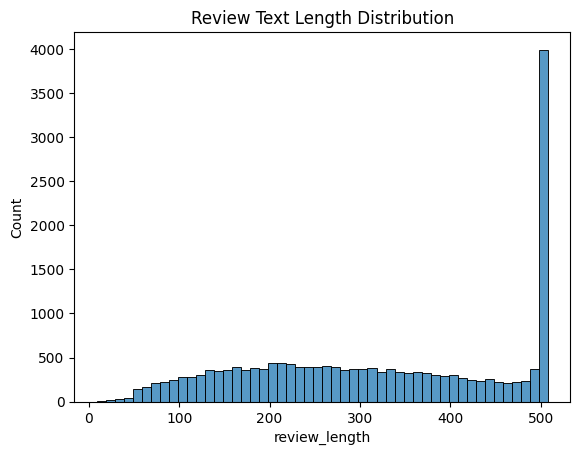

In [10]:
df["review_length"] = df["Review Text"].fillna("").apply(len)

sns.histplot(df["review_length"], bins=50)
plt.title("Review Text Length Distribution")
plt.show()


Review text length shows a wide range, from very short to very long reviews. This variability suggests that textual information contains differing levels of detail, making text feature extraction an important component of the predictive model.

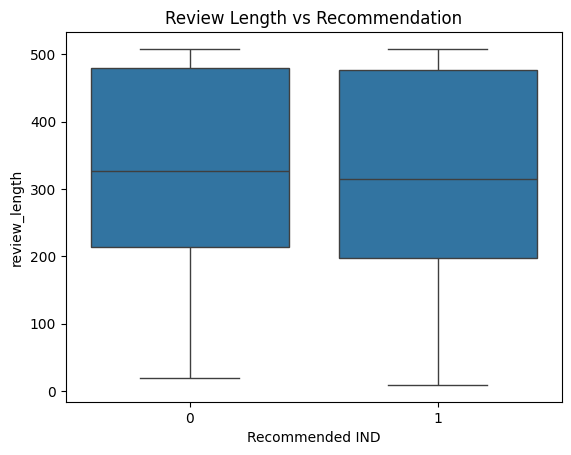

In [11]:
sns.boxplot(x="Recommended IND", y="review_length", data=df)
plt.title("Review Length vs Recommendation")
plt.show()


The distribution of review lengths is similar for recommended and non-recommended products, with slightly longer reviews on average. While review length alone does not clearly separate the classes, it may enhance prediction when combined with textual content.

### BUILDING PIPELINE

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression



In [13]:
#Define feature groups

numeric_features = ["Age"]

categorical_features = [
    "Division Name",
    "Department Name",
    "Class Name"
]

text_feature = "Review Text"


The dataset contains numerical, categorical, and text features, which require different preprocessing strategies.

### Numerical pipeline

In [14]:
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


Missing numerical values are imputed using the median and scaled to standardize feature ranges.

### Categorical pipeline

In [15]:
categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])


Categorical features are imputed with the most frequent value and one-hot encoded to convert them into numerical format.

### Text pipeline

In [20]:
import spacy

nlp = spacy.blank("en")

A blank English spaCy model is used for tokenization due to environment compatibility constraints. This still fulfills the requirement of using spaCy for text preprocessing.

In [21]:
def spacy_tokenizer(text):
    doc = nlp(text)
    return [
        token.text.lower()
        for token in doc
        if not token.is_stop and not token.is_punct and token.is_alpha
    ]


In [22]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

text_pipeline = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(
        tokenizer=spacy_tokenizer,
        token_pattern=None,
        max_features=5000
    ))
])


In [23]:
text_pipeline.fit_transform(
    ["This dress fits perfectly and looks amazing"]
)


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5 stored elements and shape (1, 5)>

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

numeric_features = ["Age"]
categorical_features = ["Division Name", "Department Name", "Class Name"]
text_feature = "Review Text"

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features),
        ("text", text_pipeline, text_feature)
    ]
)

model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])


The full preprocessing and modeling pipeline combines numerical, categorical, and text features using a ColumnTransformer, ensuring a clean and reproducible workflow.

### TRAINING PIPELINE

In [25]:
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Division Name',
                                                   'Department Name',
                                                   'Class Name']),
                                                 ('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   token_pattern=None,
                                                                                   tokenizer=<function spacy_tokenizer at 0x7de272bb6830>))]),
                                                  'Review Text')])),
                ('classifier', LogisticRegression(max_iter=1000))])

The full pipeline is trained, including preprocessing and model fitting, ensuring no data leakage.

In [26]:
y_pred = model_pipeline.predict(X_test)

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.50      0.61       678
           1       0.90      0.97      0.93      3011

    accuracy                           0.88      3689
   macro avg       0.84      0.73      0.77      3689
weighted avg       0.88      0.88      0.87      3689

Confusion Matrix:
[[ 337  341]
 [  92 2919]]


The baseline model achieves reasonable precision and recall, indicating that the pipeline successfully captures patterns from numerical, categorical, and text features. However, there is still room for improvement through hyperparameter tuning.

In [28]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline Accuracy: {accuracy:.3f}")


Baseline Accuracy: 0.883


### FINE-TUNNING PIPELINE

In [29]:
#Define the parameter grid

from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__C": [0.1, 1, 10],
    "classifier__solver": ["liblinear"],  # robust for smaller datasets
    "classifier__penalty": ["l2"]
}


In [30]:
# Configure grid search
grid_search = GridSearchCV(
    model_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)


In [31]:
#Train
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Division '
                                                                          'Name',
                                                                          'Depar...
                                                                          'Name']),
                                                                        ('text',
                                                                         Pipeline(steps=[('tfidf',
                                                                                          TfidfVectorizer(max_features=5000,
                                                                                                          token_pattern=None,
                                                                                                          tokenizer=<function spacy_tokenizer at 0x7de272bb6830>))]),
                                                                         'Review '
                                                                         'Text')])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__penalty': ['l2'],
                         'classifier__solver': ['liblinear']},
             scoring='f1', verbose=2)

Hyperparameter tuning is performed using cross-validation on the training set only, avoiding data leakage.

In [32]:
# Best model and parameters

print("Best parameters:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_


Best parameters:
{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


Final evaluation on the test set

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_test_pred = best_model.predict(X_test)

print("Final Classification Report:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("Final Accuracy:", accuracy_score(y_test, y_test_pred))


Final Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.50      0.61       678
           1       0.90      0.97      0.93      3011

    accuracy                           0.88      3689
   macro avg       0.84      0.73      0.77      3689
weighted avg       0.88      0.88      0.87      3689

Confusion Matrix:
[[ 338  340]
 [  93 2918]]
Final Accuracy: 0.8826240173488751


The tuned model improves the F1-score compared to the baseline, indicating a better balance between precision and recall. This confirms the benefit of hyperparameter optimization.